# Mortgage Loans: Predict on new data

In [6]:
import pandas as pd
import numpy as np
import pickle
import plotly.graph_objects as go

## Read in the pickle files

In [7]:
# dataframes for visualization
approved=pd.read_csv('../model_components/approved_loans.csv')
denied=pd.read_csv('../model_components/denied_loans.csv')

In [8]:
# random forest model
filename = open('../model_components/loan_approval_rf_model.pkl', 'rb')
rf = pickle.load(filename)
filename.close()

In [9]:
# encoder1
filename = open('../model_components/loan_approval_onehot_encoder.pkl', 'rb')
encoder1 = pickle.load(filename)
filename.close()

In [10]:
# ss_scaler1: monthly_return
filename = open('../model_components/loan_approval_ss_scaler1.pkl', 'rb')
ss_scaler1 = pickle.load(filename)
filename.close()

In [11]:
# ss_scaler2: ln_total_income
filename = open('../model_components/loan_approval_total_income.pkl', 'rb')
ss_scaler2 = pickle.load(filename)
filename.close()

In [12]:
# ss_scaler3: loan_amount
filename = open('../model_components/loan_approval_loan_amount.pkl', 'rb')
ss_scaler3 = pickle.load(filename)
filename.close()

In [14]:
# Remember: the order of arguments must match the order of features
features = [
'Credit_History',
'LoanAmount',
'Loan_Amount_Term',
'ApplicantIncome',
'CoapplicantIncome',
'Property_Area',
'Gender',
'Education',
'Self_Employed',
'Married'
 ]

## Write a function to preprocess and predict

In [15]:
## Create a function that can take list of valid inputs & make a prediction

def make_predictions(listofargs, Threshold):
    try:
        # the order of the arguments must match the order of the features
        df = pd.DataFrame(columns=features) 
        df.loc[0] = listofargs
        
        # convert arguments from integers to floats:
        for var in ['Credit_History', 'LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']:
            df[var]=int(df[var])

        # recode a few columns using the same steps we employed on the training data
        df['Gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
        df['Education'].replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
        df['Married'].replace({'Yes': 1, 'No': 0}, inplace = True)
        df['Self_Employed'].replace({'Yes': 1, 'No': 0}, inplace = True)
        df['LoanAmount'] = df['LoanAmount']*1000

        # transform the categorical variable using the same encoder we trained previously
        ohe=pd.DataFrame(encoder1.transform(df[['Property_Area']]).toarray())
        col_list = ['Property_Area_{}'.format(item) for item in ['Semiurban', 'Urban', 'Rural']]
        ohe.columns=col_list
        df = pd.concat([df, ohe],axis=1)

        # create new features using the scalers we trained earlier
        ln_monthly_return_raw  = np.log(df['LoanAmount']/df['Loan_Amount_Term']).values
        ln_total_income_raw = np.log(int(df['ApplicantIncome']) + int(df['CoapplicantIncome']))
        ln_LoanAmount_raw = np.log(1000*df['LoanAmount'])
        df['ln_monthly_return'] = ss_scaler1.transform(np.array(ln_monthly_return_raw).reshape(-1, 1))
        df['ln_total_income'] = ss_scaler2.transform(np.array(ln_total_income_raw).reshape(-1, 1)) 
        df['ln_LoanAmount'] = ss_scaler3.transform(np.array(ln_LoanAmount_raw).reshape(-1, 1)) 

        # drop & rearrange the columns in the order expected by your trained model!
        df=df[['Gender', 'Education', 'Self_Employed', 'Married','Credit_History',
           'Property_Area_Semiurban', 'Property_Area_Urban', 'Property_Area_Rural', 'ln_monthly_return',
           'ln_total_income', 'ln_LoanAmount']]

        prob = rf.predict_proba(df)
        raw_approval_prob=prob[0][1]
        Threshold=Threshold*.01
        approval_func = lambda y: 'Approved' if raw_approval_prob>Threshold else 'Denied'
        formatted_denial_prob = "{:,.1f}%".format(100*prob[0][0])
        formatted_approval_prob = "{:,.1f}%".format(100*prob[0][1])
        return approval_func(raw_approval_prob), formatted_approval_prob, formatted_denial_prob

    except:
        return 'Invalid inputs','Invalid inputs','Invalid inputs'

## Predicting on new data

In [19]:
# make some fake data
fake1=[1, 130.0, 360.0, 4500.0, 1500.0, 'Rural', 'Female', 'Graduate', 'Yes','Yes']
fake2=[0, 60, 180, 3000, 5000, 'Urban', 'Male', 'Graduate', 'Yes','Yes']
fake3=[1, 2000, 360, 6500, 3000, 'Semiurban', 'Male', 'Not Graduate', 'No','No']

In [20]:
# example 1
make_predictions(fake1, 83)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


('Denied', '57.5%', '42.5%')

In [21]:
# example 2
make_predictions(fake2, 40)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


('Denied', '16.5%', '83.5%')

In [22]:
# example 3
make_predictions(fake3, 70)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


('Denied', '46.7%', '53.3%')

## Visualize the new data

In [23]:
fake1

[1, 130.0, 360.0, 4500.0, 1500.0, 'Rural', 'Female', 'Graduate', 'Yes', 'Yes']

In [24]:
newdata=pd.DataFrame([fake1], columns=features)
newdata['Combined_Income']=newdata['ApplicantIncome'] + newdata['CoapplicantIncome']
newdata

,Credit_History,LoanAmount,Loan_Amount_Term,ApplicantIncome,CoapplicantIncome,Property_Area,Gender,Education,Self_Employed,Married,Combined_Income
0,1,130.0,360.0,4500.0,1500.0,Rural,Female,Graduate,Yes,Yes,6000.0


In [27]:
# plotly visualization of Loan Status

def make_loans_cube(*args):
    newdata=pd.DataFrame(args, columns=features)
    newdata['Combined_Income']=newdata['ApplicantIncome'] + newdata['CoapplicantIncome']

    trace0=go.Scatter3d(
        x=approved['LoanAmount'],
        y=approved['Combined_Income'],
        z=approved['Loan_Amount_Term'],
        name='Approved',
        mode='markers',
        text = list(zip(
            ["Credit: {}".format(x) for x in approved['Credit_History']], 
            ["<br>Education: {}".format(x) for x in approved['Education']],
            ["<br>Property Area: {}".format(x) for x in approved['Property_Area']],
            ["<br>Gender: {}".format(x) for x in approved['Gender']],
            ["<br>Education: {}".format(x) for x in approved['Education']],
            ["<br>Self-Employed: {}".format(x) for x in approved['Self_Employed']],
            ["<br>Married: {}".format(x) for x in approved['Married']]
                )) ,
        hovertemplate =
            '<b>Loan Amount: $%{x:.0f}K</b>'+
            '<br><b>Income: $%{y:.0f}</b>'+
            '<br><b>Term: %{z:.0f}</b>'+
            '<br>%{text}',
        hoverinfo='text',
        marker=dict(size=6, color='blue', opacity=0.4))

    trace1=go.Scatter3d(
        x=denied['LoanAmount'],
        y=denied['Combined_Income'],
        z=denied['Loan_Amount_Term'],
        name='Denied',
        mode='markers',
        text = list(zip(
            ["Credit: {}".format(x) for x in denied['Credit_History']], 
            ["<br>Education: {}".format(x) for x in denied['Education']],
            ["<br>Property Area: {}".format(x) for x in denied['Property_Area']],
            ["<br>Gender: {}".format(x) for x in denied['Gender']],
            ["<br>Education: {}".format(x) for x in denied['Education']],
            ["<br>Self-Employed: {}".format(x) for x in denied['Self_Employed']],
            ["<br>Married: {}".format(x) for x in denied['Married']]
                )) ,
        hovertemplate =
            '<b>Loan Amount: $%{x:.0f}K</b>'+
            '<br><b>Income: $%{y:.0f}</b>'+
            '<br><b>Term: %{z:.0f}</b>'+
            '<br>%{text}',
        hoverinfo='text',
        marker=dict(size=6, color='red', opacity=0.4))

    trace2=go.Scatter3d(
        x=newdata['LoanAmount'],
        y=newdata['Combined_Income'],
        z=newdata['Loan_Amount_Term'],
        name='Applicant',
        mode='markers',
        text = list(zip(
            ["Credit: {} ".format(x) for x in newdata['Credit_History']],
            ["<br>Education: {} ".format(x) for x in newdata['Education']],
            ["<br>Property Area: {}".format(x) for x in newdata['Property_Area']],
            ["<br>Gender: {}".format(x) for x in newdata['Gender']],
            ["<br>Education: {}".format(x) for x in newdata['Education']],
            ["<br>Self-Employed: {}".format(x) for x in newdata['Self_Employed']],
            ["<br>Married: {}".format(x) for x in newdata['Married']]
                )) ,
        hovertemplate =
            '<b>Loan Amount: $%{x:.0f}K</b>'+
            '<br><b>Income: $%{y:.0f}</b>'+
            '<br><b>Term: %{z:.0f}</b>'+
            '<br>%{text}',
        hoverinfo='text',
        marker=dict(size=15, color='yellow'))


    layout = go.Layout(title="Loan Status",
                        showlegend=True,
                            scene = dict(
                            xaxis=dict(title='Loan Amount'),
                            yaxis=dict(title='Combined Income'),
                            zaxis=dict(title='Term')
                    ))
    fig=go.Figure([trace0, trace1, trace2], layout)
    return fig


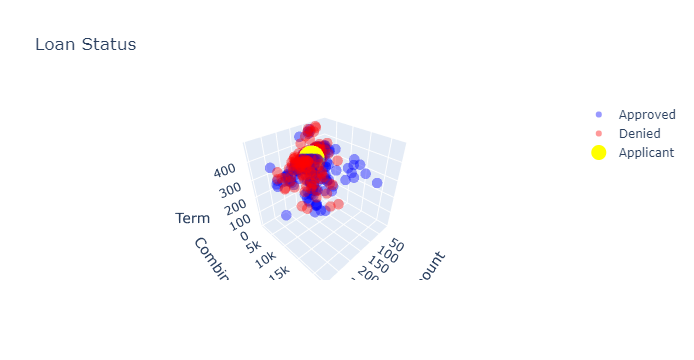

In [28]:
make_loans_cube(fake1)